In [1]:
from IPython.display import SVG
import numpy as np
from scipy.stats import norm
import time
import pandas as pd 
from sklearn.neighbors.kde import KernelDensity
import matplotlib.pyplot as plt
import pandas as pd
import csv
from synbioTools import tensorChem
from keras import models
from keras import optimizers
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.utils import to_categorical
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from Bio import SeqIO
from Bio.PDB.Polypeptide import d1_to_index
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_classification
""" Import_packages"""
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from sklearn.cross_validation import train_test_split
import numpy as np
from scipy.stats import norm
import time
from sklearn.neighbors.kde import KernelDensity
import matplotlib.pyplot as plt
import pandas as pd
import csv
from synbioTools import tensorChem

Using TensorFlow backend.
C:\Users\DR\Anaconda3\envs\my-rdkit-env\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


## Load Data

In [2]:
""" Read csv file and return it as a panda dataframe(dictionary) by biopython """
def readfasta(ffile):
    """ Read fasta file, return dictionary """
    record_iterator = SeqIO.parse(ffile, "fasta")
    a=pd.DataFrame(columns=['id','seq'])
    for i in record_iterator:
        a.loc[a.shape[0]+1] = [i.id,str(i.seq[:])] 
    return a

In [3]:
""" Read csv file and return it as a panda dataframe(dictionary) """
def read_csv(path):
    """ Read csv, return a panda dataframe(dictionary) """
    df = pd.read_csv(path)
    return df

In [4]:
"""Load chemicals information and convert the chemical info to SMILES format """
def load_chemicals(properties="Solubility",path=""):
    
    SolubilityData = read_csv(path) # read csv
    chems=[] # variable to store the 
    
#     # change column names of 
#     SolubilityData.rename(columns={ SolubilityData.columns[1]: properties }, inplace=True)
#     SolubilityData.rename(columns={ SolubilityData.columns[0]: "Compound" }, inplace=True)
#     SolubilityData.rename(columns={ SolubilityData.columns[2]: "SMILES" }, inplace=True)
    
    for row in range(0,len(SolubilityData['SMILES'])):
        chems.append( Chem.MolFromSmiles(SolubilityData['SMILES'][row] ) )
    SolubilityData['SMILES'] = chems
    return SolubilityData # return the data list which contains the three input

In [5]:
""" Visualize seq length and solu """
# plot the histogram of solubility
import re
import seaborn as sns
import os

def visu_KDE(Values,name,path):
    
    if re.search(r'length',str(name)):
        length=[]
        for i in Values:
            length.append(len(i))
        train_y_plot = pd.Series( np.squeeze(length), name=name)
    else:
        train_y_plot = pd.Series( np.squeeze(Values), name=name)
    mean = train_y_plot.mean()
    std = train_y_plot.std()
    print("The mean of the "+name+" is: " + str(mean))
    print("The S.D. of the "+name+" is: " + str(std))
    f,ax= plt.subplots(figsize = (14, 10))
    sns.distplot(train_y_plot, kde=True, rug=True, hist=True)
    ax.set_title("Density Plot of "+name, fontsize=18, position=(0.5,1.05))
    plt.savefig(path, bbox_inches='tight')

In [6]:
from collections import Counter
"""Visualize seq vocab"""
# Count amino acid and convert to vocab
def vis_seq_elements(X_seq,path):
    tmp=""
    for i in X_seq:
        tmp = tmp + str(i)
    c2 = Counter(tmp)
    print("The frequency is: " + str(c2))
    print("Amino acids type is: " + str(len(c2)))
    print("They are: " + str(c2.keys()))
    k = pd.DataFrame.from_dict([c2])
    classes=len(c2.keys())

    f,ax= plt.subplots(figsize = (14, 10))
    g=sns.barplot(data=k,ax=ax)
    for p in g.patches:
            g.annotate("%.0f" % p.get_height(), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', rotation=0, xytext=(0, 20), textcoords='offset points')
    ax.set_title("Frequencies Hist of Amino Acids", fontsize=18, position=(0.5,1.05))
    plt.savefig(path, bbox_inches='tight')
    return list(c2.keys())

## Tokenization

In [7]:
"""Convert SMILES into fingerprint"""
def chemFP(chem, FINGERPRINT_SIZE, MIN_PATH=1, MAX_PATH=5):
    fpix = AllChem.RDKFingerprint(chem, minPath=MIN_PATH, maxPath=MAX_PATH, fpSize=FINGERPRINT_SIZE)    
    fpix = [int(x) for x in list(fpix.ToBitString())]
    return fpix

In [8]:
""" Encode a chemical as a tensor by concatenating fingerprints up to desired depth """
def tensorChem(chems, FINGERPRINT_SIZE, CHEMDEPTH):
    TRAIN_BATCH_SIZE = len(chems)   
    Xs = np.zeros( (TRAIN_BATCH_SIZE, FINGERPRINT_SIZE, CHEMDEPTH) )
    # print(Xs.shape)
    for i in range(0, len(chems)-1):
        for k in range(0, CHEMDEPTH):
            fpix = chemFP(chems[i],FINGERPRINT_SIZE, k+1, k+1)
            Xs[i, :, k] = fpix
    return Xs

In [9]:
""" Flatten the tensor into a two dimentional vector(feature mapping) """
# The original vector shape
def flatten_chem(X_chem):
    
    depth = 4
    fpSize = 1024
    tc = tensorChem(X_chem,fpSize, depth)
    print('The original vector shape:\n'+str(tc.shape))
    # The flattened vector shape
    train_x_flatten = tc.reshape(tc.shape[0], -1)
    print('The flattened vector shape:\n '+str(train_x_flatten.shape))
    return train_x_flatten

In [10]:
def one_hot(seq):
    """ Convert amino acid to one-hot vector stack """
    # Generate amino acids one-hot dict
    to_one_hot = dict()
    for i, a in enumerate(d1_to_index):
        v = np.zeros(len(d1_to_index))
        v[i] = 1
        to_one_hot[a] = v
    ix = []
    result = []
    # Tranfer the seq by the dict
    for m in seq:
        result.append(to_one_hot[m])
    result = np.array(result)
    return np.reshape(result, (1, result.shape[0], result.shape[1]))

def index_seq(seq,vocab):
    """ Convert amino acid to numerical index """
    index=[]
    for i in seq:
        if i in vocab: 
            p=vocab.index(i)
            index.append(p)
        else:
            index.append('?')
    index = index
    return index

def tensor_pad(seqs,vocab,max_length=False):
    # Init seqs vector
    seqs_index=[]
    # Transfer seqs into index vector
    for seq in seqs:
        seqs_index.append(index_seq(seq,vocab))
    # Pad the seqs
    if max_length==False:
        pad=pad_sequences(seqs_index, maxlen=None, dtype='int32',padding='pre', truncating='pre', value=0.)
    else:
        pad=pad_sequences(seqs_index, maxlen=max_length, dtype='int32',padding='pre', truncating='pre', value=0.)
#     # one-hot encode the pad
#     encoded = to_categorical(pad)

    #return seqs_index
    return pad

In [11]:
"""Class to seq"""
def catagorite_EC(EC):
    tmp=[]
    for i in EC:
        i=i.split('.')
        for k, a in enumerate(i):
            if re.search(r'n',a):
                a=re.search(r'\d',a)[0]
            i[k]=int(a)
        if len(i)<=3:
            i.append(0)
        tmp.append(i)
    return tmp

In [12]:
"""Class to index"""
from sklearn import preprocessing
def catagorite_EC_index(EC):
    encoder = preprocessing.LabelEncoder()
    encoder.fit(EC)
    EC = encoder.transform(EC)
    num_classes = np.max(EC) + 1

    # Convert labels to one hot
    EC = to_categorical(EC, num_classes)
    return EC

In [13]:
""" Hardmax the labels """
# convert train_y into a vector range from 0 to 1
def hardmax(Y_b4):
    Y_b4=np.array([int(i) for i in Y_b4.T])
    Y=np.zeros((1,len(Y_b4)))
    mean = Y_b4.mean()
    std = Y_b4.std()
    for i in range(0,len(Y_b4)-1):
        if (Y_b4[i] >=mean):
            Y[0][i]=1
        else:
            Y[0][i]=0

    print('There are '+ str(list(np.squeeze(Y)).count(1)) + ' soluble chemicals (positive samples) and ' + str(list(np.squeeze(Y)).count(0)) + ' insoluble chemicals (negative samples).')

    # plot the input fingerprint length distribution plot
    plt.plot(np.squeeze(Y))
    plt.ylabel('solubility')
    plt.xlabel('fingerprints')
    plt.title("fingerprint and solubility distribution in binary classification" )
    plt.show()
    
    return np.squeeze(Y)

## NN Architecture

In [14]:
"""NN Model"""
from keras import backend as K
from keras.layers import Dropout
from keras.models import Model
from keras.layers import Input, Dense

# Customized R2 ACC method
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()))
            
#Try Adam as optimizer and implement time-based learning rate decay lr *= (1. / (1. + self.decay * self.iterations)
         
def create_network(layer_type=("LSTM",[4096,32,32,1]),outputlayer_type='linear_regression',optimizer='Adam',Init='he_init',vocab=d1_to_index,drop_out=0.5):
    # Setup hyperparameters for optimizers
    Adam = optimizers.Adam(lr=0.0075, beta_1=0.9, beta_2=0.999, epsilon=None, decay=1e-6, amsgrad=False)
    sgd=optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
    
    
    # Start neural network
    network = Sequential()
    if layer_type[0]=="LSTM":
        network.add(Embedding(output_dim=layer_type[1][1], input_dim=len(vocab), input_length=(layer_type[1][0])))
        for i in layer_type[1][1:-1]: 
            network.add(LSTM(i, return_sequences=True))  # returns a sequence of vectors of dimension 32
            network.add(Dropout(drop_out))
        #     network.add(LSTM(32))  # return a single vector of dimension 32
        network.add(Flatten())
    elif layer_type[0]=="DFF":
        network.add(layers.Dense(units=layer_type[1][1], activation='relu', input_shape=(layer_type[1][0],)))
        if len(layer_type[1])>=4:
            for i in layer_type[1][2:-1]:
                # Add fully connected layer with a ReLU activation function
                network.add(layers.Dense(units=i, activation='relu'))

    if outputlayer_type=='linear_regression':
        if layer_type[1][-1]!=0:

        # Add fully connected layer with a sigmoid activation function
            network.add(layers.Dense(units=layer_type[1][-1]))

        # Compile neural network
        if optimizer == 'bgd':
            network.compile(loss='mean_squared_error',optimizer= sgd,metrics=[coeff_determination]) # Accuracy performance metric-R2 sgd
            print("Optimizer batch gradient decent; Loss mean_squared_error.")
        elif optimizer == 'Adam':
            network.compile(loss='mean_squared_error',optimizer= Adam,metrics=[coeff_determination]) # Accuracy performance metric-R2 Adam
            print("Optimizer Adam; Loss mean_squared_error.")
            
    elif outputlayer_type=='binary_classifier':
        if layer_type[1][-1]!=0:
        # Add fully connected layer with a sigmoid activation function
            network.add(layers.Dense(units=layer_type[1][-1], activation='sigmoid'))

        # Compile neural network
        if optimizer == 'sgd':
            network.compile(loss='binary_crossentropy',optimizer= sgd,metrics=['accuracy']) # Accuracy performance metric sgd
            print("Optimizer batch gradient decent; binary_crossentropy.")
        elif optimizer == 'Adam':
            network.compile(loss='binary_crossentropy',optimizer= Adam,metrics=['accuracy']) # Accuracy performance metric Adam
            print("Optimizer Adam; binary_crossentropy.")
    
    elif outputlayer_type=='multiple_classifier':
        if layer_type[1][-1]!=0:
        # Add fully connected layer with a softmax activation function
            network.add(Dense(layer_type[1][-1], activation='softmax'))
        # Compile neural network
        if optimizer == 'bgd':
            network.compile(loss='categorical_crossentropy',optimizer= sgd,metrics=['accuracy']) # Accuracy performance metric-R2 sgd
            print("Optimizer batch gradient decent; Loss mean_squared_error.")
        elif optimizer == 'Adam':
            network.compile(loss='categorical_crossentropy',optimizer= Adam,metrics=['accuracy']) # Accuracy performance metric-R2 Adam
            print("Optimizer Adam; Loss mean_squared_error.")
    
    # Return compiled network
    return network

In [15]:
def combine_models(Seq_NN,Seq_input,Chem_NN,Chem_input):
    Seq_input = Input(shape=(Seq_input,))
    encoded_seq = Seq_NN(Seq_input)
    Chem_input = Input(shape=(Chem_input,))
    encoded_chem = Chem_NN(Chem_input)
    merged_NN = layers.concatenate([encoded_seq, encoded_chem])
    merged_NN =  layers.Dense(units=1, activation='sigmoid')(merged_NN)
    combined_model = Model([Seq_input, Chem_input], merged_NN)
    combined_model.compile(loss='mse',optimizer='adam', metrics=[coeff_determination])
    return combined_model

In [16]:
import statsmodels.api as sm
import math

def get_r2_numpy(x, y):
    slope, intercept = np.polyfit(x, y, 1)
    r_squared = 1 - (sum((y - (slope * x + intercept))**2) / ((len(y) - 1) * np.var(y, ddof=1)))
    return r_squared

def get_r2_scipy(x, y):
    _, _, r_value, _, _ = stats.linregress(x, y)
    return r_value**2

def get_r2_statsmodels(x, y):
    return sm.OLS(y, sm.add_constant(x)).fit().rsquared

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [18]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix
import itertools
def confusion_heatmap(Y_seq_EC_tokenized_index,Y_pre_EC,name):

    tmp=[]
    for i in Y_pre_EC:
        num = np.argmax(i)
        tmp.append(num)
    Y_re=[np.argmax(i) for i in Y_seq_EC_tokenized_index]
    Y_re=np.array(Y_re).reshape(np.array(Y_re).shape[0],)
    tmp=np.array(tmp)

    table=pd.crosstab(Y_re,tmp, rownames=['Actual'], colnames=['Predicted'], margins=True)
    table.to_csv(name + "error_map.csv")

    cnf_matrix = confusion_matrix(Y_re, tmp)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=d2_to_index,title='Confusion matrix , without normalization')
    plt.savefig(name + "confusion_heatmap.svg", bbox_inches='tight')
    plt.close()

In [19]:
# Plot linear regression
def linear_regression(Train_Y,Train_Y_pred,Test_Y,Test_Y_pred,path,i):
        r_square=get_r2_statsmodels(Train_Y_pred,Train_Y)
        q_square=get_r2_statsmodels(Test_Y_pred,Test_Y)
        
        # Plot Training-set
        model=LinearRegression()
        model.fit(Train_Y_pred,Train_Y)
        ax=plt.gca()
        plt.scatter(Train_Y_pred,Train_Y)
        y_train_pred=model.predict(Train_Y_pred)
        plt.title('Linear regression of solubility training prediction in fold '+str(i+1))
        plt.text(0.5,0.7,"The R-square value is %.2f " % r_square, verticalalignment='bottom', horizontalalignment='right',transform=ax.transAxes)
        plt.plot(Train_Y_pred,y_train_pred,color='black',linewidth=3,label="R-square")
        plt.legend(loc=2)
        plt.xlabel("train  (mol/L)")
        plt.ylabel("theorical  (mol/L)")

        # Plot Testing-set
        model=LinearRegression()
        model.fit(Test_Y_pred,Test_Y)

        plt.scatter(Test_Y_pred,Test_Y)
        y_train_pred=model.predict(Test_Y_pred)

        plt.text(0.5,0.645,"The Q-square value is %.2f " % q_square,verticalalignment='bottom',color='red', horizontalalignment='right',transform=ax.transAxes)
        plt.plot(Test_Y_pred,y_train_pred,color='red',linewidth=3,label="Q-square")
        plt.legend(loc=2)
        
        plt.savefig(path+'linear_regression_fold_'+str(i+1)+'.svg', bbox_inches='tight')
        plt.close()

In [20]:
# Linear regression INFO

class error_ana_info():
    def __init__(self):
        self._train_metric = None
        self._test_metric = None
        self.df = None
        self.mdif = None
    
    def add_info(self,train_metric,test_metric):
        if self._train_metric is None or  self._test_metric is None:
            self._train_metric = np.array(train_metric)
            self._test_metric = np.array(test_metric)
        else:
            self._train_metric = np.vstack((self._train_metric, train_metric))
            self._test_metric = np.vstack((self._test_metric, test_metric))
    
    def generate_csv(self,row_names,name):
        if (self._train_metric.size!=0 and self._test_metric.size!=0):
            _acc=[]
            _acc_in_val_acc=[]
            _valacc=[]
            _epochs=[]
            _train_err=[]

            # Calculate max train_acc
            for i in self._train_metric:
                _acc.append(np.max(i))

            # Calculate max test_acc and optimal_epo
            for index,i in enumerate(self._test_metric):
                _valacc.append(np.max(i))
                _epochs.append(np.where(i==np.max(i,axis=0))[0][0]+1)
                _acc_in_val_acc.append(self._train_metric[index][np.where(i==np.max(i,axis=0))[0][0]])
            
#            print(_acc,_acc_in_val_acc)
            # Calculate max training_err
            for i in range(len(_acc)):
                _train_err.append('%.2f%%' %(((_acc[i]-_acc_in_val_acc[i])/_acc_in_val_acc[i])*100))
                
            self.df=[_acc,_acc_in_val_acc,_valacc,_epochs,_train_err]
            self.df = pd.DataFrame(self.df)
            self.df.set_index([row_names],inplace=True)
            
            # Calculate Average Value
            meanv=[]
            for index, row in self.df.iterrows():
                
                row=list(row)
                if re.search(r'\%',str(row[1])):
                    row=[float(j.strip("%")) for j in row]
                    meanv.append(str(np.mean(row))+"%")
                else:
                    row=[float(j) for j in row]
                    meanv.append(np.mean(list(row)))

            self.df['B']=meanv
            
            col=[]
            for i in range(1,len(self.df.iloc[0])):
                col.append("Fold "+str(i))
            col.append('Average Value')
            self.df.columns = col
            self.df.to_csv(name)
            
    def generate_model_info(self,epochs,batch_size,initialization,bias,name):
        Hyperparameters=pd.Series(data=['epochs','batch_size','initialization','bias'],name='Hyperparameters')
        Settings=pd.Series(data=[epochs,batch_size,initialization,bias],name='Settings')
        Settings.rename('Settings')
        self.mdif=pd.DataFrame()
        self.mdif= self.mdif.join(Hyperparameters, how='right')
        self.mdif= self.mdif.join(Settings)
        self.mdif.to_csv(name,index=False) 

In [21]:
# define the training visualization function
def training_vis(hist,outputlayer,name):
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    if outputlayer=='linear_regression':
        acc = hist.history['coeff_determination']
        val_acc = hist.history['val_coeff_determination']
    elif outputlayer=='binary_classifier':
        acc = hist.history['acc']
        val_acc = hist.history['val_acc']
    elif outputlayer=='multiple_classifier':
        acc = hist.history['acc']
        val_acc = hist.history['val_acc']

    # make a figure
    fig = plt.figure(figsize=(8,4))
    # subplot loss
    ax1 = fig.add_subplot(121)
    ax1.plot(loss,label='train_loss')
    ax1.plot(val_loss,label='val_loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss on Training and Validation Data')
    ax1.legend()
    # subplot acc
    ax2 = fig.add_subplot(122)
    if outputlayer=='linear_regression':
        ax2.plot(acc,label='train_coeff_determination')
        ax2.plot(val_acc,label='val_coeff_determination')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Coeff_determination')
        ax2.set_title('Coeff_determination  on Training and Validation Data')
    elif outputlayer=='binary_classifier':
        ax2.plot(acc,label='train_accuracy')
        ax2.plot(val_acc,label='val_accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Accuracy  on Training and Validation Data')
    elif outputlayer=='multiple_classifier':
        ax2.plot(acc,label='train_accuracy')
        ax2.plot(val_acc,label='val_accuracy')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Accuracy')
        ax2.set_title('Accuracy  on Training and Validation Data')
    
    ax2.legend()
    plt.tight_layout()
    plt.savefig(name, bbox_inches='tight')
    plt. close()

In [22]:
### """StratifiedKFold"""
from scipy import stats
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import KFold 
from sklearn.linear_model import LinearRegression
import os
import matplotlib.pyplot as plt
import matplotlib
from keras.layers import Dropout

def k_folds_NN(network=None, X=None, Y=None, batch_size=50, epochs=5, path='C:/Users/DR/Desktop/P2/Latent-master/pic/Seq_linear_regression_dropout_1138/', Init='he_init', outputlayer_type='binary_classifier'):
    # Store training info
    info=error_ana_info()

    # Split the dataset in 3 folds
    sfolder = KFold(n_splits=3,random_state=0,shuffle=True)
    if len(X)>=2:
        sfolder.get_n_splits(X[0],Y)

        # If directory dosn't exixst, then create directory.  
        if not os.path.exists(path):
            os.mkdir(path)

    #    early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=8,verbose=0, mode='auto')## Callback for early stopping the training

        #K-folds iteration    
        for i, (train, test) in enumerate(sfolder.split(X[0],Y)):
            X_train , X_test=[] , []
            for j in X:
                X_train, X_test = X_train + [j[train]], X_test + [j[test]]
            y_train, y_test = Y[train], Y[test]

            # Train the model with each combination of folds
            hist = network.fit(X_train, y_train,batch_size=batch_size, epochs=epochs, validation_data=(X_test,y_test))

            if outputlayer_type=='linear_regression':
                # Plot Linear Regression
                info.add_info(hist.history['coeff_determination'],hist.history['val_coeff_determination'])
                linear_regression(Train_Y=y_train,Train_Y_pred=network.predict(X_train),Test_Y=y_test,Test_Y_pred=network.predict(X_test),path=path,i=i)
            elif outputlayer_type=='binary_classifier':
                info.add_info(hist.history['acc'],hist.history['val_acc'])
            elif outputlayer_type=='multiple_classifier':
                info.add_info(hist.history['acc'],hist.history['val_acc'])
                confusion_heatmap(y_test,network.predict(X_test),path + "fold_" + str(i+1) + "_")

        # hist = network.fit(X_train,  y_train,batch_size=batch_size, epochs=epochs, validation_data=(X_test,y_test), callbacks=[early_stopping])

            # Plot runtime
            training_vis(hist,outputlayer_type,path+"train_fold "+str(i+1)+".svg")

            # Save NN Model
            network.save(path+'batch_size_'+str(batch_size)+'epochs_'+str(epochs)+'fold_'+str(i+1)+'.h5')
            i=i+1
    else:
        X=np.squeeze(X)
        sfolder.get_n_splits(X,Y)

        # If directory dosn't exixst, then create directory.  
        if not os.path.exists(path):
            os.mkdir(path)

    #    early_stopping = EarlyStopping(monitor='val_loss',min_delta=0,patience=8,verbose=0, mode='auto')## Callback for early stopping the training

        #K-folds iteration    
        for i, (train, test) in enumerate(sfolder.split(X,Y)):
            X_train, X_test = X[train], X[test]
            y_train, y_test = Y[train], Y[test]

            # Train the model with each combination of folds

            hist = network.fit(X_train, y_train,batch_size=batch_size, epochs=epochs, validation_data=(X_test,y_test))

            if outputlayer_type=='linear_regression':
                # Plot Linear Regression
                info.add_info(hist.history['coeff_determination'],hist.history['val_coeff_determination'])
                linear_regression(Train_Y=y_train,Train_Y_pred=network.predict(X_train),Test_Y=y_test,Test_Y_pred=network.predict(X_test),path=path,i=i)
            elif outputlayer_type=='binary_classifier':
                info.add_info(hist.history['acc'],hist.history['val_acc'])
            elif outputlayer_type=='multiple_classifier':
                info.add_info(hist.history['acc'],hist.history['val_acc'])
                confusion_heatmap(y_test,network.predict(X_test),path + "fold_" + str(i+1) + "_")

        # hist = network.fit(X_train,  y_train,batch_size=batch_size, epochs=epochs, validation_data=(X_test,y_test), callbacks=[early_stopping])

            # Plot runtime
            training_vis(hist,outputlayer_type,path+"train_fold "+str(i+1)+".svg")

            # Save NN Model
            network.save(path+'batch_size_'+str(batch_size)+'epochs_'+str(epochs)+'fold_'+str(i+1)+'.h5')
            i=i+1
        
    # Output training information
    if outputlayer_type=='linear_regression':
        info.generate_csv(['R2','R2_opt','Q2','Epochs_opt','Train_err'],path+"training_result.csv")
    elif outputlayer_type=='binary_classifier':
        info.generate_csv(['Train_Acc','Train_Acc_opt','Test_Acc','Epochs_opt','Train_err'],path+"training_result.csv")
    elif outputlayer_type=='multiple_classifier':
        info.generate_csv(['Train_Acc','Train_Acc_opt','Test_Acc','Epochs_opt','Train_err'],path+"training_result.csv")
    
    if Init=='he_init':
        info.generate_model_info(epochs,batch_size,"He_Init","Enabled",path+'model_info.csv')
    elif Init=='random_no_bias':
        info.generate_model_info(epochs,batch_size,"Random","False",path+'model_info.csv')
    elif Init=='random_with_bias':
        info.generate_model_info(epochs,batch_size,"Random","True",path+'model_info.csv')
    
    return hist

## Main

In [23]:
"""Set working directory"""
# If directory dosn't exixst, then create directory.   
path="C:/Users/DR/Desktop/P2/Latent-master/pic/Functional_Test/"
if not os.path.exists(path):
    os.mkdir(path)

In [24]:
"""Load Data"""
# Load seqs_thermoatability
non_thermophilic_proteins = readfasta("C:/Users/DR/Desktop/P2/Latent-master/data/thermostability/non-thermophilic_proteins.txt")
thermophilic_proteins = readfasta("C:/Users/DR/Desktop/P2/Latent-master/data/thermostability/thermophilic_proteins.txt")
thermophilic_proteins['Thermostability']='1'
non_thermophilic_proteins['Thermostability']='0'
# Append the thermophilic to the non-thermophilic
sequence_data=pd.concat([thermophilic_proteins,non_thermophilic_proteins])
sequence_data=sequence_data.sample(frac=1)
# Init input and Y
X_seq=sequence_data['seq']
Y_seq=sequence_data['Thermostability']

# Load chems_solubility
chem_data = load_chemicals("","C:/Users/DR/Desktop/P2/Latent-master/data/solubility/delaney.csv")
chem_data.rename(columns={ chem_data.columns[1]: "Solubility"}, inplace=True)
X_chem=chem_data['SMILES']
Y_chem=np.array(chem_data['Solubility'])

# Load EC data
EC=read_csv("C:/Users/DR/Desktop/P2/Latent-master/data/ec/ecseq.csv")
EC.drop(['Uniprot'], axis=1,inplace=True)
EC = EC[pd.notnull(EC['EC'])]
EC = EC[pd.notnull(EC['Sequence'])]
X_seq_EC=EC['Sequence']
Y_seq_EC=EC['EC']

In [ ]:
"""Visualize data"""
# If directory dosn't exixst, then create directory.   
path="C:/Users/DR/Desktop/P2/Latent-master/pic/Functional_Test/"
if not os.path.exists(path):
    os.mkdir(path)
# Visualize the solubility and seq_length distribution
visu_KDE(Y_chem,"chem solubility",path+'Density Plot of chem solubility.svg')
visu_KDE(X_seq,"seq length",path+'Density Plot of seqs length.svg')

In [ ]:
"""Tokenize data"""
# Generate vocab
d1_to_index=vis_seq_elements(X_seq,path+'Frequencies Hist of Amino Acids Thermostability.svg')
d2_to_index=vis_seq_elements(X_seq_EC,path+'Frequencies Hist of Amino Acids EC.svg')

# Tokenlize chem
X_chem=flatten_chem(X_chem)
# Tokenlize seq_thermostability
X_seq=tensor_pad(X_seq,d1_to_index)
# Tokenlize seq_EC
X_seq_EC=tensor_pad(X_seq_EC,d2_to_index,max_length=200)
# Tokenize EC
Y_seq_EC_tokenized_index=catagorite_EC_index(Y_seq_EC)
Y_seq_EC_tokenized=catagorite_EC(Y_seq_EC)
# Hardmax solubility
Y_chem_hardmax=hardmax(Y_chem)
# Hardmax thermostability
Y_seq_hardmax=hardmax(Y_seq)

## Chem->properties

In [ ]:
"""Solubility prediction"""
# Build two sequential NN
Chem_NN=create_network(layer_type=("DFF",[X_chem.shape[1],20,7,5,1]),outputlayer_type='linear_regression',optimizer='Adam',Init='he_init')
Chem_NN.summary()
hist=k_folds_NN(network=Chem_NN,X=[X_chem],Y=Y_chem,batch_size=1144, epochs=107,path='C:/Users/DR/Desktop/P2/Latent-master/pic/test/',Init='he_init',outputlayer_type='linear_regression')

## Seq->properties

## Chem/Seq->binary classification

In [ ]:
"""Solubility prediction"""
# Build two sequential NN
Chem_NN=create_network(layer_type=("DFF",[X_chem.shape[1],20,7,5,1]),outputlayer_type='linear_regression',optimizer='Adam',Init='he_init')
Chem_NN.summary()
hist=k_folds_NN(network=Chem_NN,X=X_chem,Y=Y_chem_hardmax,batch_size=1144, epochs=1,path='C:/Users/DR/Desktop/P2/Latent-master/pic/Optimal/Chem_binary classification/',Init='he_init',outputlayer_type='binary_classifier')

In [ ]:
"""Thermostability prediction"""
# Build two sequential NN
Seq_NN=create_network(layer_type=("LSTM",[X_seq.shape[1],32,32,1]),outputlayer_type='binary_classifier',optimizer='Adam' ,Init='he_init')
Seq_NN.summary()
hist=k_folds_NN(network=Seq_NN,X=X_seq,Y=Y_seq_hardmax,batch_size=6, epochs=1,path='C:/Users/DR/Desktop/P2/Latent-master/pic/Optimal/Seq_binary classification/',Init='he_init',outputlayer_type='binary_classifier')

## Seq->multiple classification

In [ ]:
"""Thermostability prediction"""
# Build two sequential NN
Seq_NN_multi=create_network(layer_type=("LSTM",[X_seq_EC.shape[1],32,32,502]),outputlayer_type='multiple_classifier',optimizer='Adam',Init='he_init',vocab=d2_to_index)
# Seq_NN_multi=create_network(layer_type=("LSTM",[X_seq_EC.shape[1],1,502]),outputlayer_type='multiple_classifier',optimizer='Adam',Init='he_init',vocab=d2_to_index)
Seq_NN_multi.summary()
hist=k_folds_NN(network=Seq_NN_multi,X=X_seq_EC,Y=Y_seq_EC_tokenized_index,batch_size=128, epochs=50,path='C:/Users/DR/Desktop/P2/Latent-master/pic/Optimal/Seq_multiple classification/',Init='he_init',outputlayer_type='multiple_classifier')

## Chem + Seq->combined NN->linear regression

In [25]:
"""Load Data"""
kcat = load_chemicals("Kcat", "C:/Users/DR/Desktop/P2/Latent-master/data/kinetics/kcatseq.csv")
kcat.drop(['Uniprot','Compound','Reaction'], axis=1,inplace=True)
kcat = kcat[pd.notnull(kcat['Sequence'])]
kcat = kcat[pd.notnull(kcat['SMILES'])]
kcat = kcat[pd.notnull(kcat['Kcat'])]
kcat=kcat.sample(frac=1)
kcat.reset_index(drop=True, inplace=True)
X_chem_kcat=kcat['SMILES']
X_seq_kcat=kcat['Sequence']
Y_kcat=kcat['Kcat']

In [ ]:
"""Visualize data"""
# If directory dosn't exixst, then create directory.   
path="C:/Users/DR/Desktop/P2/Latent-master/pic/Combined_Model/"
if not os.path.exists(path):
    os.mkdir(path)
# Visualize the solubility and seq_length distribution
visu_KDE(Y_kcat,"Kcat",path+'Density Plot of chem solubility.svg')
visu_KDE(X_seq_kcat,"seq length",path+'Density Plot of seqs length.svg')

The frequency is: Counter({'L': 104427, 'A': 97005, 'G': 85177, 'V': 81102, 'E': 76381, 'S': 65434, 'I': 64362, 'D': 63163, 'K': 61197, 'R': 59839, 'T': 58374, 'P': 54160, 'F': 42703, 'N': 42504, 'Q': 38179, 'Y': 34182, 'M': 27423, 'H': 27003, 'C': 14775, 'W': 13771, 'X': 13, 'U': 4})
Amino acids type is: 22
They are: dict_keys(['M', 'L', 'R', 'G', 'A', 'S', 'Q', 'P', 'E', 'W', 'K', 'D', 'T', 'V', 'I', 'C', 'Y', 'H', 'F', 'N', 'X', 'U'])
The original vector shape:
(2542, 1024, 4)
The flattened vector shape:
 (2542, 4096)
There are 65 soluble chemicals (positive samples) and 2477 insoluble chemicals (negative samples).


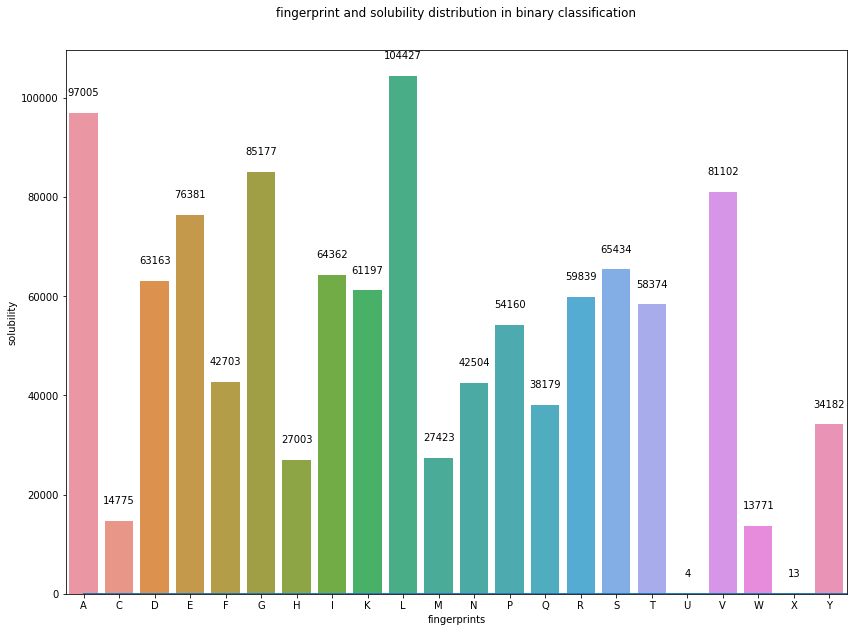

In [27]:
"""Tokenize data"""
# Generate vocab
d3_to_index=vis_seq_elements(X_seq_kcat,path+'Frequencies Hist of Amino Acids Thermostability.svg')

# Tokenlize chem
X_chem_kcat=flatten_chem(X_chem_kcat)
# Tokenlize seq_thermostability
X_seq_kcat=tensor_pad(X_seq_kcat,d3_to_index)
# Hardmax thermostability
Y_kcat_hardmax=hardmax(Y_kcat)

In [28]:
"""Build NN"""
# Build two sequential NN
Seq_NN=create_network(layer_type=("LSTM",[X_seq_kcat.shape[1],32,32,0]),outputlayer_type='linear_regression',optimizer='Adam',Init='he_init',vocab=d3_to_index,drop_out=0.9)
Chem_NN=create_network(layer_type=("DFF",[X_chem_kcat.shape[1],20,7,5,0]),outputlayer_type='linear_regression',optimizer='Adam',Init='he_init')
Seq_NN.summary()
Chem_NN.summary()

Optimizer Adam; Loss mean_squared_error.
Optimizer Adam; Loss mean_squared_error.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 3712, 32)          704       
_________________________________________________________________
lstm_1 (LSTM)                (None, 3712, 32)          8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 3712, 32)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 3712, 32)          8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 3712, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 118784)            0         
Total params: 17,344
Trainable params: 17,344
Non-trainable 

In [36]:
# Build functional API combined NN
combine_model = combine_models(Seq_NN,X_seq_kcat.shape[1],Chem_NN,X_chem_kcat.shape[1])
combine_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 3712)         0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 4096)         0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 118784)       17344       input_5[0][0]                    
__________________________________________________________________________________________________
sequential_6 (Sequential)       (None, 5)            82127       input_6[0][0]                    
__________________________________________________________________________________________________
concatenat

In [38]:
hist=k_folds_NN(network=combine_model,X=[X_seq_kcat]+[X_chem_kcat],Y=Y_kcat,batch_size=32, epochs=50,path=path,Init='he_init',outputlayer_type='linear_regression')

Train on 1694 samples, validate on 848 samples
Epoch 1/50
1694/1694 [==============================] - 274s 161ms/step - loss: 3557435848.0061 - coeff_determination: -0.1190 - val_loss: 3101406481.7302 - val_coeff_determination: -0.1081
Epoch 2/50
1694/1694 [==============================] - 274s 161ms/step - loss: 3557435780.8652 - coeff_determination: -0.1241 - val_loss: 3101406481.7302 - val_coeff_determination: -0.1081
Epoch 3/50
1694/1694 [==============================] - 275s 162ms/step - loss: 3557436045.4219 - coeff_determination: -0.1191 - val_loss: 3101406481.7302 - val_coeff_determination: -0.1081
Epoch 4/50
1694/1694 [==============================] - 273s 161ms/step - loss: 3557435973.2302 - coeff_determination: -0.1033 - val_loss: 3101406481.7302 - val_coeff_determination: -0.1081
Epoch 5/50
1694/1694 [==============================] - 275s 163ms/step - loss: 3557435978.0820 - coeff_determination: -0.1164 - val_loss: 3101406481.7302 - val_coeff_determination: -0.1081
Epo

Epoch 44/50
1694/1694 [==============================] - 271s 160ms/step - loss: 3557435856.2222 - coeff_determination: -0.1243 - val_loss: 3101406481.7302 - val_coeff_determination: -0.1081
Epoch 45/50
1694/1694 [==============================] - 272s 161ms/step - loss: 3557435923.2848 - coeff_determination: -0.1206 - val_loss: 3101406481.7302 - val_coeff_determination: -0.1081
Epoch 46/50
1694/1694 [==============================] - 273s 161ms/step - loss: 3557435860.1323 - coeff_determination: -0.1089 - val_loss: 3101406481.7302 - val_coeff_determination: -0.1081
Epoch 47/50
1694/1694 [==============================] - 273s 161ms/step - loss: 3557435690.1526 - coeff_determination: -0.1013 - val_loss: 3101406481.7302 - val_coeff_determination: -0.1081
Epoch 48/50
1694/1694 [==============================] - 271s 160ms/step - loss: 3557435644.3835 - coeff_determination: -0.1237 - val_loss: 3101406481.7302 - val_coeff_determination: -0.1081
Epoch 49/50
1694/1694 [======================

Epoch 37/50
1695/1695 [==============================] - 269s 159ms/step - loss: 1607575309.8074 - coeff_determination: -0.1071 - val_loss: 7002891491.9979 - val_coeff_determination: -0.0875
Epoch 38/50
1695/1695 [==============================] - 269s 159ms/step - loss: 1607575309.2593 - coeff_determination: -0.1083 - val_loss: 7002891491.9979 - val_coeff_determination: -0.0875
Epoch 39/50
1695/1695 [==============================] - 269s 159ms/step - loss: 1607575347.0131 - coeff_determination: -0.1104 - val_loss: 7002891491.9979 - val_coeff_determination: -0.0875
Epoch 40/50
1695/1695 [==============================] - 268s 158ms/step - loss: 1607575386.5271 - coeff_determination: -0.1168 - val_loss: 7002891491.9979 - val_coeff_determination: -0.0875
Epoch 41/50
1695/1695 [==============================] - 268s 158ms/step - loss: 1607575347.9370 - coeff_determination: -0.1126 - val_loss: 7002891491.9979 - val_coeff_determination: -0.0875
Epoch 42/50
1695/1695 [======================

KeyboardInterrupt: 

## Small sample

In [29]:
path="C:/Users/DR/Desktop/P2/Latent-master/pic/Functional_Test/"
X_seq_kcat_small=X_seq_kcat[1:256]
X_chem_kcat_small=X_chem_kcat[1:256]
Y_kcat_small=Y_kcat[1:256]

In [ ]:
"""Build NN"""
# Build two sequential NN
Seq_NN=create_network(layer_type=("LSTM",[X_seq_kcat_small.shape[1],32,32,1]),outputlayer_type='linear_regression',optimizer='Adam',Init='he_init',vocab=d3_to_index,drop_out=0.95)
Chem_NN=create_network(layer_type=("DFF",[X_chem_kcat_small.shape[1],20,7,5,1]),outputlayer_type='linear_regression',optimizer='Adam',Init='he_init')
Seq_NN.summary()
Chem_NN.summary()

# Build functional API combined NN
combine_model = combine_models(Seq_NN,X_seq_kcat_small.shape[1],Chem_NN,X_chem_kcat_small.shape[1])
combine_model.summary()

In [31]:
hist=k_folds_NN(network=combine_model,X=[X_seq_kcat_small]+[X_chem_kcat_small],Y=Y_kcat_small,batch_size=128, epochs=500,path=path,Init='he_init',outputlayer_type='linear_regression')

C:\Users\DR\Anaconda3\envs\my-rdkit-env\lib\site-packages\pandas\core\series.py:841: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Train on 170 samples, validate on 85 samples
Epoch 1/500
170/170 [==============================] - 19s 110ms/step - loss: nan - coeff_determination: nan - val_loss: nan - val_coeff_determination: nan
Epoch 2/500
170/170 [==============================] - 17s 97ms/step - loss: nan - coeff_determination: nan - val_loss: nan - val_coeff_determination: nan
Epoch 3/500
170/170 [==============================] - 17s 99ms/step - loss: nan - coeff_determination: nan - val_loss: nan - val_coeff_determination: nan
Epoch 4/500
170/170 [==============================] - 17s 100ms/step - loss: nan - coeff_determination: nan - val_loss: nan - val_coeff_determination: nan
Epoch 5/500
170/170 [==============================] - 17s 99ms/step - loss: nan - coeff_determination: nan - val_loss: nan - val_coeff_determination: nan
Epoch 6/500
170/170 [==============================] - 17s 101ms/step - loss: nan - coeff_determination: nan - val_loss: nan - val_coeff_determination: nan
Epoch 7/500
170/170 [=

KeyboardInterrupt: 

## Transfer learning

In [ ]:
hist_pretrain=k_folds_NN(network=Chem_NN,X=[X_chem_kcat],Y=Y_kcat,batch_size=128, epochs=500,path="C:/Users/DR/Desktop/P2/Latent-master/pic/Combined_Model/pretrained/",Init='he_init',outputlayer_type='linear_regression')